11 KV MODEL 

In [25]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
11 kV edition – builds fault history, trains Poisson-LSTM on 2018-2023 data,
and writes 2024 forecasts (monthly / quarterly / yearly) per switch.
"""

from __future__ import annotations
import logging, math, sys, json, numpy as np, pandas as pd
import torch, torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
filterwarnings("ignore", category=FutureWarning)

# ─── paths ──────────────────────────────────────────────────────────────
FAULT_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/DATA_GENERATION/FAULT DATA/HT_fault_cable_info_processed_without_affected.csv")

# ⬇⬇⬇  use your **11 kV** cable master here
CABLE_CSV = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/11_KV_FINAL_HEALTH/AFINAL_full.csv")

OUT_DIR   = Path("/media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health_11KV")

# ─── constants / hyper-params ───────────────────────────────────────────
MIN_YEAR, TARGET_YEAR   = 2016, 2024
TRAIN_YEARS             = list(range(2018, TARGET_YEAR))

# ⬇⬇⬇  keep ONLY 11 kV
KEEP_VOLTAGES           = {11}

BATCH, EPOCHS, PATIENCE = 64, 40, 12
LR, WD, CLIP            = 1e-3, 1e-5, 1.0
HID, LAY, DROP, EMB     = 512, 2, 0.1, 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); np.random.seed(42)

logging.basicConfig(format="%(asctime)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helper functions … (UNCHANGED) ──────────────────────────────────────
# v_to_num, norm_sw, month_range, sincos, months_to_quarters
# ─── 1 · fault history … (UNCHANGED except v-filter) ─────────────────────
# ─── 2 · Poisson-LSTM dataset & training … (UNCHANGED) ──────────────────
# ─── 3 · 2024 forecasts & save CSVs … (UNCHANGED) ───────────────────────


# ─── helper functions ───────────────────────────────────────────────────
def v_to_num(v):
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
             .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
             .str.replace(r"\D+","",regex=True)
             .replace("", np.nan)).astype("Int64")

def month_range(a,b): return pd.period_range(f"{a}-01", f"{b}-12", freq="M")

def sincos(idx):
    ang = 2*np.pi*idx.month.values/12
    return np.stack([np.sin(ang), np.cos(ang)], 1)

def months_to_quarters(mat):
    q=np.zeros((mat.shape[0],4))
    q[:,0]=mat[:,0:3].sum(1); q[:,1]=mat[:,3:6].sum(1)
    q[:,2]=mat[:,6:9].sum(1); q[:,3]=mat[:,9:12].sum(1)
    return q

# ─── 1 · fault history ──────────────────────────────────────────────────
fault=pd.read_csv(FAULT_CSV,parse_dates=["TIME_OUTAGE"],low_memory=False)
sw_col="FROM_SWITCH" 
fault["SWITCH_ID"]=norm_sw(fault[sw_col])
fault=fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault=fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR,TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"]=fault["VOLTAGE"].apply(v_to_num)
    fault=fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault=fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])
fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")

idx_full=month_range(MIN_YEAR,TARGET_YEAR)
counts=(fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1]
        .groupby(["SWITCH_ID","YM"]).size()
        .unstack(fill_value=0)
        .reindex(columns=idx_full,fill_value=0).astype(float))
switches=counts.index.tolist(); sw2idx={sw:i for i,sw in enumerate(switches)}

# ─── 2 · Poisson-LSTM dataset & training ────────────────────────────────
class WinDS(Dataset):
    def __init__(self, fr):
        self.x  = torch.tensor(fr["X_seq"],dtype=torch.float32)
        self.xs = torch.tensor(fr["X_season"],dtype=torch.float32)
        self.y  = torch.tensor(fr["y_seq"],dtype=torch.float32)
        self.sw = torch.tensor(fr["sw_idx"],dtype=torch.long)
    def __len__(self): return len(self.sw)
    def __getitem__(self,i): return self.x[i],self.xs[i],self.y[i],self.sw[i]

class PoissonLSTM(nn.Module):
    def __init__(self,n_sw):
        super().__init__()
        self.emb = nn.Embedding(n_sw, EMB)
        self.rnn = nn.LSTM(3,HID,LAY,batch_first=True,
                           dropout=DROP if LAY>1 else 0.)
        self.head=nn.Sequential(nn.Linear(HID+EMB,HID),nn.ReLU(),
                                nn.Linear(HID,HID//2),nn.ReLU(),
                                nn.Linear(HID//2,12))
        self.sp = nn.Softplus()
    def forward(self,x,xs,sw):
        h,_=self.rnn(torch.cat([x,xs],-1))
        h=torch.cat([h[:,-1],self.emb(sw)],1)
        return self.sp(self.head(h))

def build_frames(years, nonzero=True):
    X_seq,X_sea,y_seq,sw_idx=[],[],[],[]
    for sw,row in counts.iterrows():
        for Y in years:
            tr,tg=month_range(Y-2,Y-1),month_range(Y,Y)
            if nonzero and row[tr].sum()==0: continue
            X_seq.append(np.log1p(row[tr]).values[:,None])
            X_sea.append(sincos(tr)); y_seq.append(row[tg].values)
            sw_idx.append(sw2idx[sw])
    return dict(X_seq=np.stack(X_seq),
                X_season=np.stack(X_sea),
                y_seq=np.stack(y_seq),
                sw_idx=np.array(sw_idx,dtype=np.int64))

train_frames=build_frames(TRAIN_YEARS,True)
ds=WinDS(train_frames); perm=np.random.permutation(len(ds))
n_val=max(1,int(.1*len(ds)))
dl_tr=DataLoader(torch.utils.data.Subset(ds,perm[:-n_val]),BATCH,shuffle=True)
dl_va=DataLoader(torch.utils.data.Subset(ds,perm[-n_val:]),BATCH,shuffle=False)

model=PoissonLSTM(len(switches)).to(DEVICE)
loss_fn,opt=nn.PoissonNLLLoss(log_input=False),torch.optim.Adam(model.parameters(),lr=LR,weight_decay=WD)

best,bad,best_ep=1e9,0,0
for ep in range(1,EPOCHS+1):
    model.train()
    for xb,xs,yb,swb in dl_tr:
        xb,xs,yb,swb=[t.to(DEVICE) for t in (xb,xs,yb,swb)]
        opt.zero_grad(); loss_fn(model(xb,xs,swb),yb).backward()
        nn.utils.clip_grad_norm_(model.parameters(),CLIP); opt.step()
    with torch.no_grad():
        v=np.mean([loss_fn(model(x.to(DEVICE),xs.to(DEVICE),sw.to(DEVICE)),
                           y.to(DEVICE)).item()
                   for x,xs,y,sw in dl_va])
    if v<best-1e-4: best,bad,best_ep,ckpt=v,0,ep,model.state_dict()
    else: bad+=1
    log(f"Epoch {ep:02d} | val-loss={v:.4f} | best={best:.4f} (ep{best_ep}) | bad={bad}")
    if bad>=PATIENCE: break
model.load_state_dict(ckpt)
log(f"Training finished in {best_ep} epochs | best val-loss={best:.4f}")

# ─── 3 · 2024 forecasts & save CSVs ─────────────────────────────────────
def months_to_quarters(mat):
    q=np.zeros((mat.shape[0],4))
    q[:,0]=mat[:,0:3].sum(1); q[:,1]=mat[:,3:6].sum(1)
    q[:,2]=mat[:,6:9].sum(1); q[:,3]=mat[:,9:12].sum(1)
    return q

eval_frames=build_frames([TARGET_YEAR],False)
mu,swids=[],[]
with torch.no_grad():
    for xb,xs,_,swb in DataLoader(WinDS(eval_frames),256,False):
        xb,xs,swb=[t.to(DEVICE) for t in (xb,xs,swb)]
        mu.append(model(xb,xs,swb).cpu().numpy())
        swids.append(swb.cpu().numpy())
MU,SWIDX=np.concatenate(mu),np.concatenate(swids)
QTRS=months_to_quarters(MU)

ym=month_range(TARGET_YEAR,TARGET_YEAR)
rows_m,rows_q,rows_y=[],[],[]
for i,ix in enumerate(SWIDX):
    sw=switches[ix]
    rows_y.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,PRED_FULL=float(MU[i].sum())))
    for m in range(12):
        rows_m.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,MONTH=m+1,
                           YM=str(ym[m]),PRED_FAULTS=float(MU[i,m])))
    for qi,qsum in enumerate(QTRS[i],1):
        rows_q.append(dict(SWITCH_ID=sw,YEAR=TARGET_YEAR,QUARTER=qi,
                           PRED_FAULTS_Q=float(qsum)))

OUT_DIR.mkdir(parents=True,exist_ok=True)
pd.DataFrame(rows_m).to_csv(OUT_DIR/"per_switch_monthly_forecasts.csv",index=False)
pd.DataFrame(rows_q).to_csv(OUT_DIR/"per_switch_quarterly_forecasts.csv",index=False)
pd.DataFrame(rows_y).to_csv(OUT_DIR/"per_switch_yearly_forecasts.csv",index=False)
log("Saved 2024 forecasts → %s", OUT_DIR.resolve())




/tmp/ipykernel_12670/2874841023.py:81: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fault["YM"]=fault["TIME_OUTAGE"].dt.to_period("M")


12:12:13 | Epoch 01 | val-loss=0.1135 | best=0.1135 (ep1) | bad=0
12:12:15 | Epoch 02 | val-loss=0.1116 | best=0.1116 (ep2) | bad=0
12:12:18 | Epoch 03 | val-loss=0.1107 | best=0.1107 (ep3) | bad=0
12:12:21 | Epoch 04 | val-loss=0.1113 | best=0.1107 (ep3) | bad=1
12:12:23 | Epoch 05 | val-loss=0.1104 | best=0.1104 (ep5) | bad=0
12:12:26 | Epoch 06 | val-loss=0.1123 | best=0.1104 (ep5) | bad=1
12:12:28 | Epoch 07 | val-loss=0.1118 | best=0.1104 (ep5) | bad=2
12:12:31 | Epoch 08 | val-loss=0.1127 | best=0.1104 (ep5) | bad=3
12:12:34 | Epoch 09 | val-loss=0.1102 | best=0.1102 (ep9) | bad=0
12:12:36 | Epoch 10 | val-loss=0.1133 | best=0.1102 (ep9) | bad=1
12:12:39 | Epoch 11 | val-loss=0.1101 | best=0.1102 (ep9) | bad=2
12:12:41 | Epoch 12 | val-loss=0.1115 | best=0.1102 (ep9) | bad=3
12:12:44 | Epoch 13 | val-loss=0.1115 | best=0.1102 (ep9) | bad=4
12:12:47 | Epoch 14 | val-loss=0.1110 | best=0.1102 (ep9) | bad=5
12:12:49 | Epoch 15 | val-loss=0.1120 | best=0.1102 (ep9) | bad=6
12:12:52 |

12:11:02 | Validation metrics (2024):  MONTH  mae=0.026  rmse=0.114 | QUARTER  mae=0.077  rmse=0.219 | YEAR  mae=0.263  rmse=0.512
12:11:03 | Saved plot → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health_11KV/forecast_vs_actual_2024.png


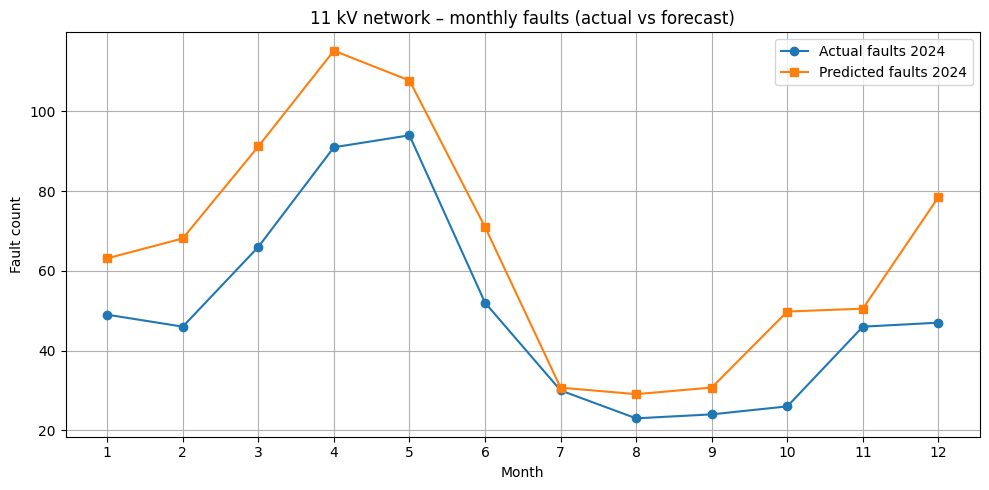

In [23]:
actual_2024 = (fault[fault["TIME_OUTAGE"].dt.year == TARGET_YEAR]
               .groupby(["SWITCH_ID", fault["TIME_OUTAGE"].dt.month])
               .size()
               .unstack(fill_value=0)
               .reindex(index=switches, columns=range(1,13), fill_value=0))

pred_m = pd.DataFrame(MU, index=switches, columns=range(1,13))
mae_m  = np.abs(pred_m - actual_2024).mean().mean()
rmse_m = np.sqrt(((pred_m - actual_2024)**2).mean().mean())

pred_q = pd.DataFrame(QTRS, index=switches, columns=range(1,5))
actual_q = actual_2024.groupby(lambda m: (m-1)//3, axis=1).sum()
mae_q  = np.abs(pred_q - actual_q).mean().mean()
rmse_q = np.sqrt(((pred_q - actual_q)**2).mean().mean())

mae_y  = np.abs(pred_m.sum(1) - actual_2024.sum(1)).mean()
rmse_y = np.sqrt(((pred_m.sum(1) - actual_2024.sum(1))**2).mean())

log(f"Validation metrics (2024):  MONTH  mae={mae_m:.3f}  rmse={rmse_m:.3f} | "
    f"QUARTER  mae={mae_q:.3f}  rmse={rmse_q:.3f} | "
    f"YEAR  mae={mae_y:.3f}  rmse={rmse_y:.3f}")

# ─── 5 · PLOT predicted vs actual monthly totals ─────────────────────────
import matplotlib.pyplot as plt
tot_pred = pred_m.sum()
tot_act  = actual_2024.sum()

plt.figure(figsize=(10,5))
plt.plot(tot_act.index, tot_act.values,  label="Actual faults 2024", marker="o")
plt.plot(tot_pred.index, tot_pred.values, label="Predicted faults 2024", marker="s")
plt.title("11 kV network – monthly faults (actual vs forecast)")
plt.xlabel("Month"); plt.ylabel("Fault count"); plt.xticks(range(1,13))
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(OUT_DIR/"forecast_vs_actual_2024.png", dpi=150)
log("Saved plot → %s", (OUT_DIR/"forecast_vs_actual_2024.png").resolve())

In [34]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from datetime import date
EXPECTED_LIFE_YEARS = 15
# 9-factor weights — AEML POV
# p stays fixed at 0.15; remaining 0.85 distributed by AEML rank order
W = dict(
    l=0.25,  # 1) Length (ℓ)
    s=0.21,  # 2) Segments (s)
    f=0.12,  # 3) Faults/km (f)
    r=0.11,  # 4) Load-range utilisation (r)
    a=0.06,  # 5) Age (a)
    i=0.05,  # 6) Interruption frequency (i)
    c=0.03,  # 7) Cyclic loading (c)
    u=0.02,  # 8) Recent-8-month faults (u)
    p=0.15   # (fixed) Predicted faults (ML) (p)
)

W = dict(
    l= 0.22,
    u= 0.20,
    f= 0.12,
    i= 0.12,
    s= 0.08,
    r= 0.06,
    c= 0.05,
    a= 0.00,
    p= 0.15
)


logging.basicConfig(format="%(asctime)s | %(message)s",
                    datefmt="%H:%M:%S", level=logging.INFO, stream=sys.stdout)
log = logging.getLogger("pipeline").info

# ─── helpers used here ──────────────────────────────────────────────────
def v_to_num(v):
    try: return float(str(v).lower().replace("kv",""))
    except: return math.nan

def norm_sw(s):
    return (s.astype(str).str.upper().str.strip()
             .str.replace(r"^(SWNO_|SWNO|SW|S)\s*", "", regex=True)
             .str.replace(r"\D+","",regex=True)
             .replace("", np.nan)).astype("Int64")

def robust(s, lo=5, hi=95):
    c=s.replace([np.inf,-np.inf],np.nan).dropna()
    if c.empty: return pd.Series(0., index=s.index)
    a,b=np.percentile(c,[lo,hi]); return ((s-a).clip(0,b-a)/(b-a+1e-9)).fillna(0.)

# ─── load forecasts & raw data ──────────────────────────────────────────
per_y = pd.read_csv(OUT_DIR/"per_switch_monthly_forecasts.csv")
agg_df = (
    per_y.groupby("SWITCH_ID", as_index=False)["PRED_FAULTS"]
      .sum()
      .rename(columns={"PRED_FAULTS": "pred_faults_2024"})
)

# Merge back into original dataframe if you want the new column there
per_y = per_y.merge(agg_df, on="SWITCH_ID", how="left")

fault = pd.read_csv(FAULT_CSV, parse_dates=["TIME_OUTAGE"], low_memory=False)
sw_col="FROM_SWITCH" 
fault["SWITCH_ID"]=norm_sw(fault[sw_col])

fault=fault.dropna(subset=["SWITCH_ID","TIME_OUTAGE"])
fault=fault[fault["TIME_OUTAGE"].dt.year.between(MIN_YEAR,TARGET_YEAR)]
if "VOLTAGE" in fault.columns:
    fault["VNUM"]=fault["VOLTAGE"].apply(v_to_num)
    fault=fault[fault["VNUM"].isin(KEEP_VOLTAGES)]
fault=fault.drop_duplicates(["SWITCH_ID","TIME_OUTAGE"])

cables=pd.read_csv(CABLE_CSV, low_memory=False).drop_duplicates("FROM_SWITCH")
cables["FROM_SWITCH"]=norm_sw(cables["FROM_SWITCH"])
# ─── 4 · health score (9 factors) ───────────────────────────────────────
cab=cables.rename(columns={"FROM_SWITCH":"SWITCH_ID",
                           "MEASUREDLENGTH":"LENGTH_M",
                           "COMMISSIONEDDATE":"DATE_INSTALLED",
                           "NO_OF_SEGMENT":"SEGMENTS"})
cab["LENGTH_KM"]=pd.to_numeric(cab["LENGTH_M"],errors="coerce")/1000
cab["DATE_INSTALLED"]=(pd.to_datetime(cab["COMMISSIONEDDATE_DT_OLDEST"],errors="coerce",utc=True)
                       .dt.tz_localize(None))

# SCADA-derived features if present
cyc=[c for c in cab.columns if c.startswith("CYCLE_Month_")]
var=[c for c in cab.columns if c.startswith("VAR_Month_")]
cab["cycle_pm"]=cab[cyc].mean(1) if len(cyc) else np.nan
cab["load_range_idx"]=(cab[var].mean(1)/cab[var].median(1)) if len(var) else np.nan

# historic faults (till 2023)
hist=fault[fault["TIME_OUTAGE"].dt.year<=TARGET_YEAR-1].groupby("SWITCH_ID").size()
cab=cab.merge(hist.rename("hist_faults"),on="SWITCH_ID",how="left").fillna({"hist_faults":0})

# predicted faults 2024 from Cell 1 CSV
cab=cab.merge(per_y.rename(columns={"PRED_FULL":"pred_faults_2024"}),
              on="SWITCH_ID",how="left").fillna({"pred_faults_2024":0})

# mean inter-fault hours
fault_naive = fault.copy()
fault_naive["TIME_OUTAGE"] = fault_naive["TIME_OUTAGE"].dt.tz_localize(None)

fault_pre2025 = fault_naive[fault_naive["TIME_OUTAGE"] < pd.Timestamp("2024-01-01")].copy()


# ── 2)  Within each switch, sort chronologically and compute Δt_h (hours) ────
fault_sorted = fault_pre2025.sort_values(["SWITCH_ID", "TIME_OUTAGE"])

fault_sorted["Δt_h"] = (
    fault_sorted.groupby("SWITCH_ID")["TIME_OUTAGE"]
    .diff()                               # timedeltas between successive rows
    .dt.total_seconds() / (3600*24)            # convert seconds → hours
)

# ── 3)  Get the mean interval per switch ─────────────────────────────────────
mean_dt = (
    fault_sorted.groupby("SWITCH_ID")["Δt_h"]
    .mean()
    .rename("mean_d")
)

# ── 4)  Merge the mean into your cable table (cab) ───────────────────────────
cab = cab.merge(mean_dt, on="SWITCH_ID", how="left")


# recent 8-month window count (relative to Jan 1, 2024)
recent_cut=(pd.Timestamp(f"{TARGET_YEAR}-01-01", tz="UTC") - pd.DateOffset(months=8))
recent_cnt=(fault[fault["TIME_OUTAGE"]>=recent_cut].groupby("SWITCH_ID").size())
cab=cab.merge(recent_cnt.rename("recent8"),on="SWITCH_ID",how="left").fillna({"recent8":0})

# age fraction of expected life
cab["DATE_INSTALLED"] = pd.to_datetime(cab["DATE_INSTALLED"])
today = pd.Timestamp(date.today())
time_elapsed = today - cab["DATE_INSTALLED"]
days_elapsed = time_elapsed.dt.days
expected_total_days = EXPECTED_LIFE_YEARS * 365
cab["a_raw"] = days_elapsed / expected_total_days

# raw factors
cab["c_raw"]=cab["cycle_pm"]
cab["r_raw"]=cab["load_range_idx"]
cab["f_raw"]=cab["hist_faults"]/cab["LENGTH_KM"].replace(0,np.nan)
cab["s_raw"]=(cab["SEGMENTS"].fillna(1)).clip(lower=0)
cab["p_raw"]=cab["pred_faults_2024"].replace(0,np.nan)
cab["i_raw"]=1/cab["mean_d"].clip(lower=1)
cab["l_raw"]=np.log1p(cab["LENGTH_KM"])    # length factor
cab["u_raw"]=cab["recent8"]

# scale to 0-1 using robust percentiles
for col in ["c_raw","r_raw","a_raw","f_raw","s_raw","p_raw","i_raw","l_raw","u_raw"]:
    cab[col[0]]=robust(cab[col])

# risk & score
risk=sum(W[k]*cab[k] for k in W.keys())
cab["health_score"]=np.rint(100*(1-risk)).clip(0,100).astype(int)
cab["health_score_10"]=np.clip(np.ceil(cab["health_score"]/10),1,10).astype(int)
cab["health_band"]=pd.cut(cab["health_score"],[-np.inf,40,60,100],
                          labels=["Poor","Moderate","Good"])

# driver labels
LABELS = {
    "c":"High cyclic loading (c)",
    "r":"Wide load-range utilisation (r)",
    "a":"Advanced cable age (a)",
    "f":"Many historic faults (f)",
    "s":"Numerous joints / segments (s)",
    "p":"High predicted faults per km (p)",
    "i":"Frequent interruptions (i)",
    "l":"Long circuit length (ℓ)",
    "u":"Recent-8-month faults(u)"
}
risk_contrib=pd.DataFrame({k:W[k]*cab[k] for k in W.keys()})
top3=risk_contrib.apply(lambda r:r.nlargest(3).index.tolist(),axis=1)
cab["primary_health_driver"]=top3.apply(lambda lst: LABELS[lst[0]])
cab["top3_health_drivers"]=top3.apply(lambda lst: "; ".join(LABELS[k] for k in lst))

# Set perfect health where no faults ever
mask_nofault=(cab["hist_faults"].eq(0)&cab["recent8"].eq(0))
cab.loc[mask_nofault,["health_score","health_score_10"]]=[100,10]
cab.loc[mask_nofault,"health_band"]="Good"
cab.loc[mask_nofault,"primary_health_driver"]="No recorded faults"
cab.loc[mask_nofault,"top3_health_drivers"]="No recorded faults"

# save CSVs
OUT_DIR.mkdir(parents=True,exist_ok=True)
cab.to_csv(OUT_DIR/"cable_health_2024_scored.csv",index=False)
cab_pred=cab[~mask_nofault]
cab_pred.to_csv(OUT_DIR/"cable_health_2024_predictions.csv",index=False)
log(f"Saved predictions for {len(cab_pred)} cables -> cable_health_2024_predictions.csv")

# ─── fleet-wide summary ─────────────────────────────────────────────────
total_predicted_faults = per_y['pred_faults_2024'].sum()
total_actual_faults_2024 = fault[fault['TIME_OUTAGE'].dt.year == TARGET_YEAR].shape[0]

log("\n" + "="*40)
log(f"FLEET-WIDE FAULT SUMMARY FOR YEAR {TARGET_YEAR}")
log("="*40)
log(f"Total Predicted Faults: {total_predicted_faults:.1f}")
log(f"Total Actual Faults:    {total_actual_faults_2024}")
log("="*40 + "\n")

# ─── validation ─────────────────────────────────────────────────────────
actual=fault[fault["TIME_OUTAGE"].dt.year==TARGET_YEAR]["SWITCH_ID"].unique()
cab["ACTUAL_FAIL_24"]=cab["SWITCH_ID"].isin(actual).astype(int)
pred=cab["health_band"].map({"Poor":1,"Moderate":1,"Good":0})
cm=confusion_matrix(cab["ACTUAL_FAIL_24"],pred)
au=roc_auc_score(cab["ACTUAL_FAIL_24"],100-cab["health_score"])
log(f"2024 confusion matrix:\n{cm}\nAUROC = {au:.3f}")
log("Factor weights applied: "+json.dumps(W))
log("Pipeline complete → %s", OUT_DIR.resolve())


12:28:41 | Saved predictions for 29527 cables -> cable_health_2024_predictions.csv
12:28:41 | 
12:28:41 | FLEET-WIDE FAULT SUMMARY FOR YEAR 2024
12:28:41 | ========================================
12:28:41 | Total Predicted Faults: 9428.7
12:28:41 | Total Actual Faults:    1108
12:28:41 | ========================================

12:28:41 | 2024 confusion matrix:
[[29688   672]
 [ 3280  1263]]
AUROC = 0.875
12:28:41 | Factor weights applied: {"l": 0.22, "u": 0.2, "f": 0.12, "i": 0.12, "s": 0.08, "r": 0.06, "c": 0.05, "a": 0.0, "p": 0.15}
12:28:41 | Pipeline complete → /media/sagark24/New Volume/MERGE CDIS/IPYNB_FILE/A_fault_model_with_health_11KV
